In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pickle
from sklearn.metrics import classification_report
from sklearn.datasets import make_circles, make_moons
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

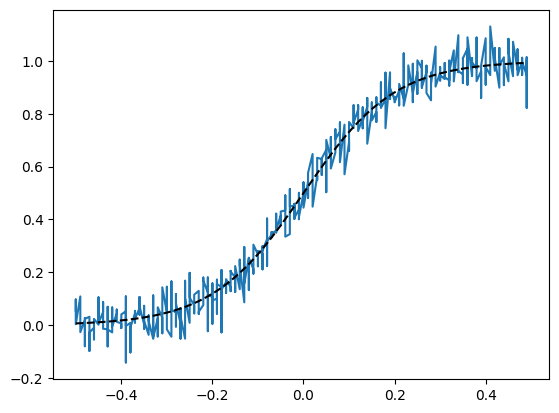

In [ ]:
X = (np.arange(100)/100 - 0.5).repeat(5)

y = 1/(1+np.exp(-10*X))
yn = np.random.normal(scale=0.05, size=y.size)+y

plt.plot(X, yn)
plt.plot(X, y, linestyle='--', c='k')

tensor_X = torch.Tensor(X.reshape(-1, 1))
tensor_y = torch.Tensor(yn.reshape(-1, 1))

HIDDEN_SIZE = 1024

weights_1 = (torch.rand(1, HIDDEN_SIZE)-.5)/10
bias_1 = torch.zeros(HIDDEN_SIZE)

weights_2 = (torch.rand(HIDDEN_SIZE, 1)-.5)/10
bias_2 = torch.zeros(1)


0.0025985509


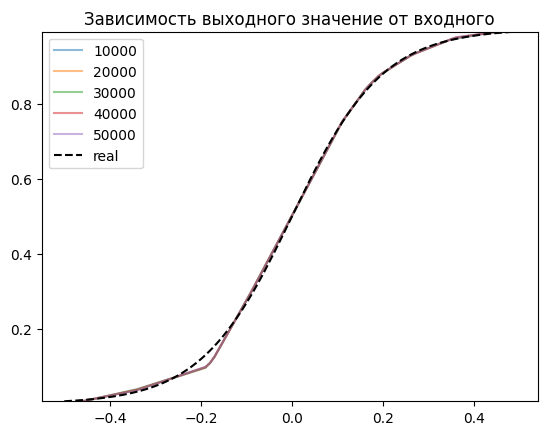

In [ ]:
relu = lambda x: torch.maximum(x, torch.Tensor([0]))

forward = lambda x: (weights_2.t()*relu((weights_1*x) + bias_1)
                      ).sum(axis=-1,keepdims=True) + bias_2
loss = lambda y, y_: ((y-y_)**2).sum(axis=-1)

def backward(X, y, y_pred):
    dL = 2*(y_pred-y)
    Ax = (weights_1*X) + bias_1
    A = relu(Ax)
    dW2 = torch.mm(A.t(), dL)
    db2 = dL.sum(axis=0)
    dA = torch.mm(dL, weights_2.t())
    dA[Ax<=0] = 0
    dW = torch.mm(X.t(), dA)
    db = dA.sum(axis=0)
    return dW, db, dW2, db2

def optimize(params, grads, lr=0.001):
    W1, b1, W2, b2 = params
    W1 -= lr*grads[0]
    W2 -= lr*grads[2]
    b1 -= lr*grads[1]
    b2 -= lr*grads[3]
    return W1, b1, W2, b2

for i in range(50000):
  output = forward(tensor_X)
  cur_loss = loss(output, tensor_y)
  grads = backward(tensor_X, tensor_y, output)
  params = [weights_1, bias_1, weights_2, bias_2]
  weights_1, bias_1, weights_2, bias_2 = optimize(params, grads, 1e-4)
  if (i+1)%10000 == 0:
      plt.plot(X, output.numpy(), label=str(i+1), alpha=0.5)
plt.title('Зависимость выходного значение от входного')
plt.plot(X, y, linestyle='--', c='k', label='real')
plt.legend()
plt.ylim(y.min(), y.max())
print(cur_loss.numpy().mean())

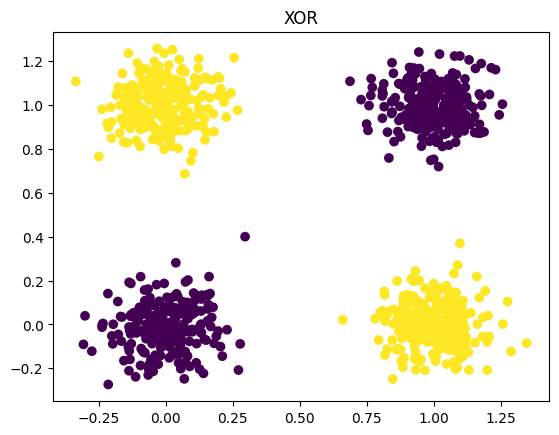

In [ ]:
X = np.random.randint(2, size=(1000, 2))

y = (X[:, 0] + X[:, 1]) % 2
X = X + np.random.normal(0, scale=0.1, size=X.shape)

plt.title('XOR')
plt.scatter(X[:, 0], X[:, 1], c=y)

tensor_X = torch.Tensor(X.reshape(-1, 2))
tensor_y = torch.Tensor(y.reshape(-1, 1))

HIDDEN_SIZE = 16

weights_1 = ((torch.rand(2, HIDDEN_SIZE)-.5)/10).detach().requires_grad_(True)
bias_1 = torch.zeros(HIDDEN_SIZE, requires_grad=True)

weights_2 = ((torch.rand(HIDDEN_SIZE, 1)-.5)/10).detach().requires_grad_(True)
bias_2 = torch.zeros(1, requires_grad=True)


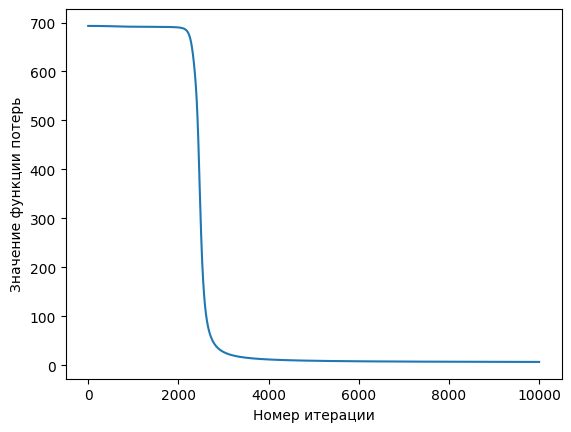

In [ ]:
def sigmoid(x):
    return 1/(1+torch.exp(-x))

def forward(x):
    hidden = torch.mm(x, weights_1) + bias_1
    hidden_nonlin = sigmoid(hidden)
    output = (weights_2.t()*hidden_nonlin).sum(axis=-1,keepdims=True) + bias_2
    return sigmoid(output)

def loss(y_true, y_pred):
    return -1*(y_true*torch.log(y_pred)+(1-y_true)*torch.log(1-y_pred)).sum()

lr = 1e-3

iters = 10000
params = [weights_1, bias_1, weights_2, bias_2]
losses = []
for i in range(iters):
    output = forward(tensor_X)
    lossval = loss(tensor_y, output)
    lossval.backward()
    for w in params:
        with torch.no_grad():
            w -= w.grad*lr
        w.grad.zero_()
    losses.append(lossval.item())

plt.xlabel('Номер итерации')
plt.ylabel('Значение функции потерь')
plt.plot(losses)

(-0.42339375607635094, 1.5201697546517035)

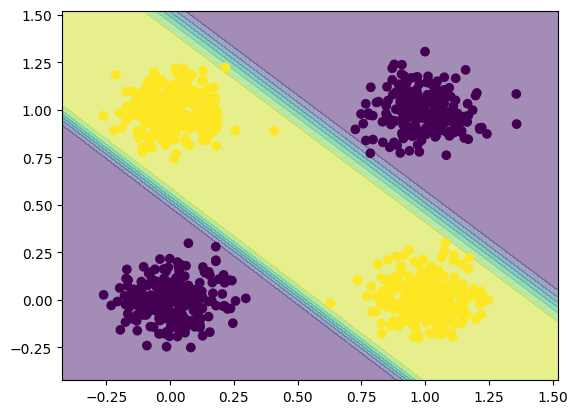

In [ ]:
X_diff = X.max() - X.min()
X_left = X.min() - 0.1*X_diff
X_right = X.max() + 0.1*X_diff
grid = np.arange(X_left, X_right, 0.01)
grid_width = grid.size
surface = []

for x1 in grid:
    for x2 in grid:
        surface.append((x1, x2))
surface = np.array(surface)

with torch.no_grad():
    Z = forward(torch.Tensor(surface)).detach().numpy()

Z = Z.reshape(grid_width, grid_width)
xx = surface[:, 0].reshape(grid_width, grid_width)
yy = surface[:, 1].reshape(grid_width, grid_width)

plt.contourf(xx, yy, Z, alpha=0.5)
ptl.title('XOR')

plt.scatter(X[:, 0], X[:, 1], c=output.detach().numpy()>0.5)

plt.xlim(X_left, X_right)
plt.ylim(X_left, X_right)

In [2]:
!wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
!tar -xvzf cifar-100-python.tar.gz

--2025-12-23 21:15:52--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  49.1MB/s    in 3.4s    

2025-12-23 21:15:56 (46.8 MB/s) - ‘cifar-100-python.tar.gz’ saved [169001437/169001437]

cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
cifar-100-python/test
cifar-100-python/meta


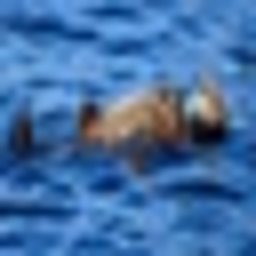

In [6]:
with open('cifar-100-python/train', 'rb') as f:
    data_train = pickle.load(f, encoding='latin1')
with open('cifar-100-python/test', 'rb') as f:
    data_test = pickle.load(f, encoding='latin1')

CLASSES = [0, 55, 58]

train_X = data_train['data'].reshape(-1, 3, 32, 32)
train_X = np.transpose(train_X, [0, 2, 3, 1])
train_y = np.array(data_train['fine_labels'])
mask = np.isin(train_y, CLASSES)
train_X = train_X[mask].copy()
train_y = train_y[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test['data'].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test['fine_labels'])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test
Image.fromarray(train_X[44]).resize((256,256))

In [ ]:
batch_size = 128
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = TensorDataset(tensor_x, tensor_y)
    dataloader[part] = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x7ddf0072ee40>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7ddf0072edb0>}

In [ ]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return torch.flatten(x, start_dim=1) # nhwc -> nm

class Cifar100_MLP(nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_MLP, self).__init__()
        self.norm = Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025])
        self.seq = nn.Sequential(
            nn.Linear(32*32*3, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, classes),
        )

    def forward(self, input):
        x = self.norm(input)
        return self.seq(x)

HIDDEN_SIZE = 10
model = Cifar100_MLP(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
model

Cifar100_MLP(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

In [ ]:
EPOCHS = 250
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
for epoch in range(EPOCHS):
    running_loss = 0.0
    model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        inputs, labels = batch

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / steps_per_epoch:.3f}')
    running_loss = 0.0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] val loss: {running_loss / steps_per_epoch_val:.3f}')
print('Обучение закончено')

[1,    12] loss: 1.044
[1,     3] val loss: 0.952
[2,    12] loss: 0.887
[2,     3] val loss: 0.849
[3,    12] loss: 0.788
[3,     3] val loss: 0.788
[4,    12] loss: 0.722
[4,     3] val loss: 0.735
[5,    12] loss: 0.678
[5,     3] val loss: 0.701
[6,    12] loss: 0.645
[6,     3] val loss: 0.645
[7,    12] loss: 0.621
[7,     3] val loss: 0.653
[8,    12] loss: 0.602
[8,     3] val loss: 0.633
[9,    12] loss: 0.584
[9,     3] val loss: 0.621
[10,    12] loss: 0.570
[10,     3] val loss: 0.637
[11,    12] loss: 0.557
[11,     3] val loss: 0.607
[12,    12] loss: 0.545
[12,     3] val loss: 0.633
[13,    12] loss: 0.534
[13,     3] val loss: 0.607
[14,    12] loss: 0.521
[14,     3] val loss: 0.592
[15,    12] loss: 0.513
[15,     3] val loss: 0.576
[16,    12] loss: 0.503
[16,     3] val loss: 0.593
[17,    12] loss: 0.495
[17,     3] val loss: 0.560
[18,    12] loss: 0.485
[18,     3] val loss: 0.561
[19,    12] loss: 0.481
[19,     3] val loss: 0.573
[20,    12] loss: 0.467
[20,  

In [ ]:
for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad():
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data

            outputs = model(inputs).detach().numpy()
            y_pred.append(outputs)
            y_true.append(labels.numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(part)
        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)

train
              precision    recall  f1-score   support

           0     0.9940    0.9940    0.9940       500
          55     0.9940    0.9960    0.9950       500
          58     1.0000    0.9980    0.9990       500

    accuracy                         0.9960      1500
   macro avg     0.9960    0.9960    0.9960      1500
weighted avg     0.9960    0.9960    0.9960      1500

--------------------------------------------------
test
              precision    recall  f1-score   support

           0     0.8364    0.9200    0.8762       100
          55     0.7404    0.7700    0.7549       100
          58     0.7674    0.6600    0.7097       100

    accuracy                         0.7833       300
   macro avg     0.7814    0.7833    0.7803       300
weighted avg     0.7814    0.7833    0.7803       300

--------------------------------------------------


(10, 3072)


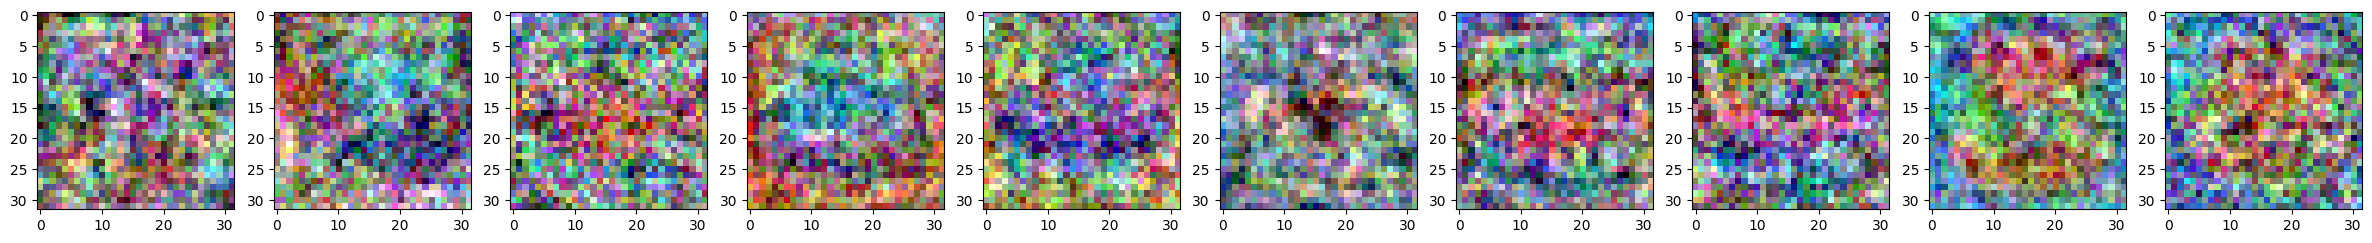

In [ ]:
weights = list(model.parameters())[0].detach().numpy()
print(weights.shape)
fig, ax = plt.subplots(1, weights.shape[0], figsize=(3*weights.shape[0], 3))
for i, ω in enumerate(weights):
    ω = ω.reshape(32, 32, 3)
    ω -= np.percentile(ω, 1, axis=[0, 1])
    ω /= np.percentile(ω, 99, axis=[0, 1])
    ω = np.clip(ω, 0, 1)
    ax[i].imshow(ω)